In [1]:
#!pip install GPyOpt
#!pip install Gpy

import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import GPy
import GPyOpt
from scipy import ndimage
from GPyOpt.methods import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from matplotlib.colors import LogNorm
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

In [2]:
data_pbp = pd.read_csv("https://raw.githubusercontent.com/damarals/RocketsAnalysis/master/data_gmm.csv")
data_pbp.head()

,ID,Place,Quarter,Minute,Second,Score,Description,locX,locY
0,21900015,Home,1st,0,25,3,[HOU 3-0] Tucker 3pt Shot: Made (3 PTS) Assist...,232,42
1,21900015,Home,1st,0,40,4,[HOU 4-0] House Jr. Free Throw 1 of 2 (1 PTS),0,-80
2,21900015,Home,1st,0,40,5,[HOU 5-0] House Jr. Free Throw 2 of 2 (2 PTS),0,-80
3,21900015,Home,1st,1,56,6,[HOU 6-0] Harden Free Throw 1 of 2 (1 PTS),0,-80
4,21900015,Home,1st,1,56,7,[HOU 7-0] Harden Free Throw 2 of 2 (2 PTS),0,-80


In [3]:
X_home = data_pbp[data_pbp.Place == "Home"].loc[:, ["locX", "locY"]].to_numpy()
X_away = data_pbp[data_pbp.Place == "Away"].loc[:, ["locX", "locY"]].to_numpy()

## Model Definition

In [4]:
bds = [{'name': 'n_components', 'type': 'discrete', 'domain': np.arange(1, 30, 1)},
       {'name': 'covariance_type', 'type': 'discrete', 'domain': (1, 2, 3, 4)}]

def gmm(parameters):
  cov_type = {1: 'full', 2: 'tied', 3: 'diag', 4: 'spherical'}
  return GaussianMixture(n_components = int(parameters[0]), covariance_type = cov_type[parameters[1]])

## Bayesian Optimization

In [5]:
# Optimization Objective
def aic_score(parameters):
  parameters = parameters[0]
  gmm_par = gmm(parameters)
  gmm_par.fit(X_home)
  score = gmm_par.aic(X_home)
  score = np.array(score)
  return score

optimizer = BayesianOptimization(f = aic_score, 
                                 domain = bds,
                                 model_type = 'GP',
                                 acquisition_type = 'EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval = True, 
                                 maximize = False, num_cores = 4, )

optimizer.run_optimization(max_iter = 30, verbosity = False)

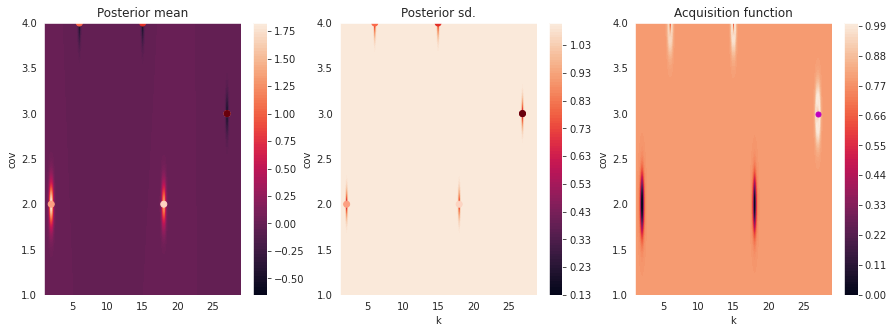

In [6]:
optimizer.plot_acquisition(label_y = "cov", label_x = "k")

In [7]:
optimizer.x_opt

array([27.,  3.])

## Fit Model

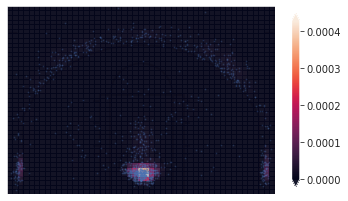

In [8]:
## Place: Home
# fit a Gaussian Mixture Model with two components
clf = gmm(optimizer.x_opt)
clf.fit(X_home)

x = np.linspace(-250., 250.)
y = np.linspace(-100., 320.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.exp(clf.score_samples(XX))
Z = Z.reshape(X.shape)

CS = plt.pcolormesh(X, Y, Z, shading = 'auto', alpha = 0.93, snap = False)
plt.colorbar(CS, shrink = 0.8, extend='both')
plt.scatter(X_home[:, 0], X_home[:, 1], alpha = 0.2, s = 0.9)

img = plt.imread("https://a.espncdn.com/redesign/assets/img/nba/bg-court-logo.png")
plt.imshow(ndimage.rotate(img, 90), extent = (-250, 250, -40, 930))

plt.title('')
#plt.axis('tight')

plt.xlim(-250, 250)
plt.ylim(-30, 320)


# Hide axes ticks
plt.xticks([])
plt.yticks([])

plt.show()

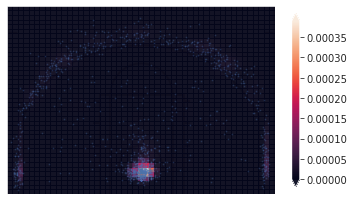

In [9]:
## Place: Away
# fit a Gaussian Mixture Model with two components
clf = gmm(optimizer.x_opt)
clf.fit(X_away)

x = np.linspace(-250., 250.)
y = np.linspace(-100., 320.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.exp(clf.score_samples(XX))
Z = Z.reshape(X.shape)

CS = plt.pcolormesh(X, Y, Z, shading = 'auto', alpha = 0.93, snap = False)
plt.colorbar(CS, shrink = 0.8, extend='both')
plt.scatter(X_away[:, 0], X_away[:, 1], alpha = 0.2, s = 0.9)

img = plt.imread("https://a.espncdn.com/redesign/assets/img/nba/bg-court-logo.png")
plt.imshow(ndimage.rotate(img, 90), extent = (-250, 250, -40, 930))

plt.title('')
#plt.axis('tight')

plt.xlim(-250, 250)
plt.ylim(-30, 320)


# Hide axes ticks
plt.xticks([])
plt.yticks([])

plt.show()